In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import platform
import os
import copy
import pooch
import tifffile
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.utils.io import load_checkpoint_path
from microsplit_reproducibility.utils.utils import (
    plot_input_patches,
    plot_individual_samples,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions,
    plot_error,
    get_single_file_predictions,
)
from careamics.utils.metrics import avg_range_invariant_psnr, avg_ssim

# Dataset specific imports...
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
# from microsplit_reproducibility.configs.data.custom_dataset_2D import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

import dill
from usplit.core.tiff_reader import save_tiff

In [3]:
from rich import pretty, print
from rich.console import Console
pretty.install()
console = Console(color_system="windows")

# **Step 2.1:** Data Preparation

Without any special modifications, **the following few steps will first choose which subset of the *HT_LIF24* dataset to use and then the corresponding test data** that we didn't use during training.

As in previous notebooks, the reason to pick a subset of the *HT_LIF24* dataset is, that we recorded this data with multiple possible learning tasks in mind. Check the <nobr>Micro$\mathbb{S}$plit</nobr> paper for all the details.

Since the channel unmixing capabilities of <nobr>Micro$\mathbb{S}$plit</nobr> are trained in a supervised way, we must later feed *(i)* input images that contain certain number of selected structures, and *(ii)* corresponding number of separate channels that show these structures separately.

The following code cell will help you to select the channels and exposure time you want to train on.
Exposure duration is a parameter of this particular experience and is defined in seconds.

    VeryLow = "2ms"
    Low = "3ms"
    Medium = "5ms"
    High = "20ms"
    VeryHigh = "500ms"

Names of channels follow the following convention:

    Nucleus = 0
    MicroTubules = 1
    NuclearMembrane = 2
    Centromere = 3

**Important:** If you used `01_train` notebook to generate a model, make sure you select the same channels and exposure time here, otherwise the model will not work properly.

In [4]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import ExposureDuration, define_experiment_config

CHANNEL_IDX_LIST, TARGET_CHANNEL_IDX_LIST, EXPOSURE_DURATION = define_experiment_config(
    num_channels=2, exposure=ExposureDuration.Medium)

Chosen structures: [0, 1]
All data channels to be loaded: [0, 1, 8]


### Download the data you need (given your choices from above)
Depending on your internet connection, this will take a while...

Appropriate noise models will only be downloaded if they were not created by executing the notebook `00_noisemodels.ipynb`.

In [5]:
DATA = pooch.create(
    path="/group/jug/aman/Datasets/HT_LIF24/",
    base_url="https://download.fht.org/jug/msplit/ht_lif24/data/",
    registry={f"ht_lif24_{EXPOSURE_DURATION}.zip": None},
)

NOISE_MODELS = pooch.create(
    path=f"./noise_models/{EXPOSURE_DURATION}/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/noise_models/{EXPOSURE_DURATION}/",
    registry={
        f"noise_model_Ch{channel_idx}.npz": None
        for channel_idx in TARGET_CHANNEL_IDX_LIST
    },
)

In [6]:
for fname in NOISE_MODELS.registry:
    NOISE_MODELS.fetch(fname, progressbar=True)
print('---------')
for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

---------

### Next, we load the data we selected above...

In [7]:
sliding_window_flag = True

if sliding_window_flag:
    print('Using sliding window dataloader')

Using sliding window dataloader

In [8]:
# setting up train, validation, and test data configs
train_data_config, val_data_config, test_data_config = get_data_configs(
    dset_type=EXPOSURE_DURATION, channel_idx_list=CHANNEL_IDX_LIST, sliding_window_flag=sliding_window_flag
)
# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(
    dset_type=EXPOSURE_DURATION, nm_path=NOISE_MODELS.path, channel_idx_list=CHANNEL_IDX_LIST
)

# start the download of required files
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / f"ht_lif24_{EXPOSURE_DURATION}.zip.unzip/{EXPOSURE_DURATION}",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=test_data_config,
    load_data_func=get_train_val_data,
)

Dataclass is <class 'careamics.lvae_training.dataset.windowed_lc_dataset.WindowedLCDLoader'>

Padding is not used with this alignement style
WindowedTilingGridIndexManager initialized with padded_data_shape: (90, 1608, 1608, 3),
WindowedTilingGridIndexManager initialized with patch_shape: (1, 64, 64, 2), stride: (1, 4, 4, 1)

Padding is not used with this alignement style
WindowedTilingGridIndexManager initialized with padded_data_shape: (12, 1608, 1608, 3),
WindowedTilingGridIndexManager initialized with patch_shape: (1, 64, 64, 2), stride: (1, 4, 4, 1)

Padding is not used with this alignement style
WindowedTilingGridIndexManager initialized with padded_data_shape: (10, 1608, 1608, 3),
WindowedTilingGridIndexManager initialized with patch_shape: (1, 64, 64, 2), stride: (1, 4, 4, 1)


### Configure `num_workers`
In Windows and MacOS, setting `num_workers > 0` for dataloaders would cause out-of-memory issue and might crash the system.

In [9]:
def get_num_workers():
    """Utility function to set num_workers based on OS."""
    if platform.system() == "Windows" or platform.system() == "Darwin":
        return 0
    else:
        return 3  # or any other number suitable for your system

experiment_params["num_workers"] = get_num_workers()

### 👇 🖼️ pick Validation or Test data to be used! 👇
**Side Note:** if you want to be well prepared for the next notebook on calibration and error estimation, you will have to do both (ie, after you have run this notebook with <i> evaluate_on_validation_data = False </i> in the cell below, return here, set <i> evaluate_on_validation_data = True </i> and re-run the subsequent cells). This will ensure that the files required in the next notebook for both the test and validation datasets are prepared correctly. More detail is provided in section 2.7


In [10]:
# by default, we will use the held out test data, 
# but if you want, we can switch to using the 
# validation data instead
evaluate_on_validation_data = True
if evaluate_on_validation_data:
    print('Will use validation data',end='')
    dset = val_dset
else:
    print('Will use test data',end='')
    dset = test_dset
print(f' (containing a total of {dset.get_num_frames()} frames).')

Will use validation data

(containing a total of 12 frames).

### Finally, let's look at bits of the data you chose!


WindowedTilingGridIndexManager initialized with padded_data_shape: (12, 1608, 1608, 3),
WindowedTilingGridIndexManager initialized with patch_shape: (1, 128, 128, 2), stride: (1, 4, 4, 1)
WindowedTilingGridIndexManager initialized with padded_data_shape: (12, 1608, 1608, 3),
WindowedTilingGridIndexManager initialized with patch_shape: (1, 64, 64, 2), stride: (1, 4, 4, 1)


[524301, 1458705, 1342144]

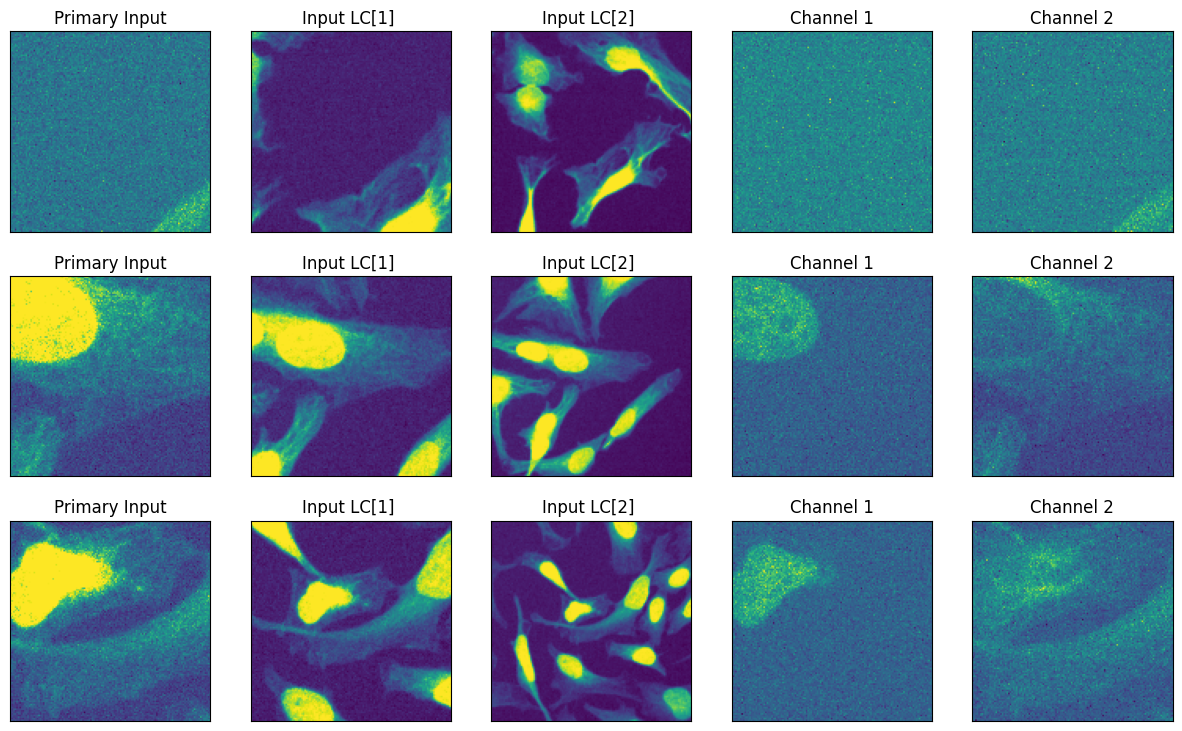

In [11]:
plot_input_patches(dataset=dset, num_channels=len(TARGET_CHANNEL_IDX_LIST), num_samples=3, patch_size=128)

# **Step 2.2:** Picking <nobr>Micro$\mathbb{S}$plit</nobr> Model to Use

For all experiments we conducted for our paper, we offer you to download and use pretrained <nobr>Micro$\mathbb{S}$plit</nobr> networks. Let's check if a fitting model is available and download it.

In [12]:
if len(TARGET_CHANNEL_IDX_LIST) == 2:
    ckpt_name = f"best_{TARGET_CHANNEL_IDX_LIST[0]}_{TARGET_CHANNEL_IDX_LIST[1]}.ckpt"
elif len(TARGET_CHANNEL_IDX_LIST) == 3:
    ckpt_name = f"best_{TARGET_CHANNEL_IDX_LIST[0]}_{TARGET_CHANNEL_IDX_LIST[1]}_{TARGET_CHANNEL_IDX_LIST[2]}.ckpt"
elif len(TARGET_CHANNEL_IDX_LIST) == 4:
    ckpt_name = f"best_{TARGET_CHANNEL_IDX_LIST[0]}_{TARGET_CHANNEL_IDX_LIST[1]}_{TARGET_CHANNEL_IDX_LIST[2]}_{TARGET_CHANNEL_IDX_LIST[3]}.ckpt"
else:
    raise ValueError(f"Unsupported number of channels: {len(TARGET_CHANNEL_IDX_LIST)}")

MODEL_CHECKPOINTS = pooch.create(
    path=f"./pretrained_checkpoints/{EXPOSURE_DURATION}/",
    base_url=f"https://download.fht.org/jug/msplit/ht_lif24/ckpts/{EXPOSURE_DURATION}",
    registry={ckpt_name: None},
)

pretrained_model_available = False
for f in MODEL_CHECKPOINTS.registry:
    if MODEL_CHECKPOINTS.is_available(f):
        MODEL_CHECKPOINTS.fetch(f"{f}", progressbar=True)
        pretrained_model_available = True

if not pretrained_model_available:
    print("No suitable pretrained model for your data seems to be available.\n"
          "Please train the model using the notebook '01_train.ipynb' or download \n"
          "correct notebook. If multiple checkpoints are present in the folder, \n"
          "remove the ones that you won't be using")

Let's see what model checkpoints you have available in the `checkpoints` folder, where the model(s) you trained with the notebook `01_train.ipynb` are stored, and the `pretrained_checkpoints` folder, where we just downloaded models into (as long as any such models exist on our servers).

In [13]:
from pathlib import Path

# Recursively search for .ckpt files in 'checkpoints' folder
ckpt_folder = Path("./checkpoints")
ckpt_folders = set()
for file in ckpt_folder.rglob("*.ckpt"):
    ckpt_folders.add(file.parent)
ckpt_folders = sorted(ckpt_folders)

# Recursively search for .ckpt files in 'pretrained_checkpoints' folder
pretrained_ckpt_folder = Path("./pretrained_checkpoints")
pretrained_ckpt_folders = set()
for file in pretrained_ckpt_folder.rglob("*.ckpt"):
    pretrained_ckpt_folders.add(file.parent)
pretrained_ckpt_folders = sorted(pretrained_ckpt_folders)

def list_available_model_checkpoint_folders():
    print('These models you have trained have been found:')
    if len(ckpt_folders)==0:
        print(' ❌ None!')
    else:
        for file in ckpt_folders:
            print(' 🟢', file)       
    if len(pretrained_ckpt_folders)==0:
        print(' ❌ None!')
    else:
        print('\nThese downloaded pretrained models have been found:')
        for file in pretrained_ckpt_folders:
            print(' 🟢', file)

## 👇 🤖 please pick one of the available models! 👇

In [14]:
list_available_model_checkpoint_folders()

These models you have trained have been found:

❌ None!

These downloaded pretrained models have been found:

🟢 pretrained_checkpoints/5ms

In [15]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# if you cut&past a path to the chosen ckpt down here,
# we will use that checkpoint, otherwise we pick one automatically.
user_selected_ckpt_folder = 'pretrained_checkpoints/5ms'
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [16]:
ckpt_folder = user_selected_ckpt_folder
if ckpt_folder == '':
    is_ckpt_auto_selected = True
    if len(pretrained_ckpt_folders)>0:
        ckpt_folder = pretrained_ckpt_folders[0]
    if len(ckpt_folders)>0: # prefer to use self-trained checkpoints
        ckpt_folder = ckpt_folders[0]
else:
    is_ckpt_auto_selected = False
    
if ckpt_folder=='':
    print("🚨 CRITICAL: No model checkpoint seems to be available!")
else:
    if is_ckpt_auto_selected:
        print("⚠️ Model checkpoint to be used was automatically selected!")
    selected_ckpt = load_checkpoint_path(str(ckpt_folder), best=True)
    print("✅ Selected model checkpoint:", selected_ckpt)

✅ Selected model checkpoint: pretrained_checkpoints/5ms/best_0_1.ckpt

# **Step 2.3:** Prepare <nobr>Micro$\mathbb{S}$plit</nobr> Model
Next, we create all the configs needed to instatiate the selected model. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [17]:
# making our data_stas known to the experiment (model) we prepare
experiment_params["data_stats"] = data_stats

# setting up model config (using default parameters)
model_config = get_model_config(**experiment_params)

# NOTE: The creation of the following configs are not strictly necessary for prediction,
#     but they ARE currently expected by the create_algorithm_config function below.
#     They act as a placeholder for now and we will work to remove them in a following release
loss_config = get_loss_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
)

/home/aman.kukde/Projects_2/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Create model and load checkpoint

In [18]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


In [19]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import load_pretrained_model
load_pretrained_model(model, selected_ckpt)

Loaded model from pretrained_checkpoints/5ms/best_0_1.ckpt


### Wanna be done quickly?
<div class="alert alert-block alert-info">
<b>Note:</b> Being quick will make the last notebook `03_calibration.ipynb` work less well. Still, if you just want to see some results the selected <nobr>Micro$\mathbb{S}$plit</nobr> model can generate, feel invited to crop down on the evaluation data we loaded above and save some time.
</div>

In [20]:
reduce_data = False

if reduce_data:
    print("Using REDUCED evaluation data for quick'n'dirty testing!")
    dset.reduce_data([0])
else:
    print('Using the full set of evaluation data!')
    print(f'(More specifically, I will use {dset.get_num_frames()} frames for evaluations.)') 

Using the full set of evaluation data!

(More specifically, I will use 12 frames for evaluations.)

# **Step 2.4:** Predictions on Uncropped Data
If a single frame has the size of a typical microscopy image, we cannot feed the entire image to <nobr>Micro$\mathbb{S}$plit</nobr> (your GPU would run out of memory). Hence, we predict results for smaller chunks of the full image, so called tiles.

When we perform tiled predicitons, we use '***inner padding***'. See a detailed explanation in our [µSplit paper](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf), and the schematic below.
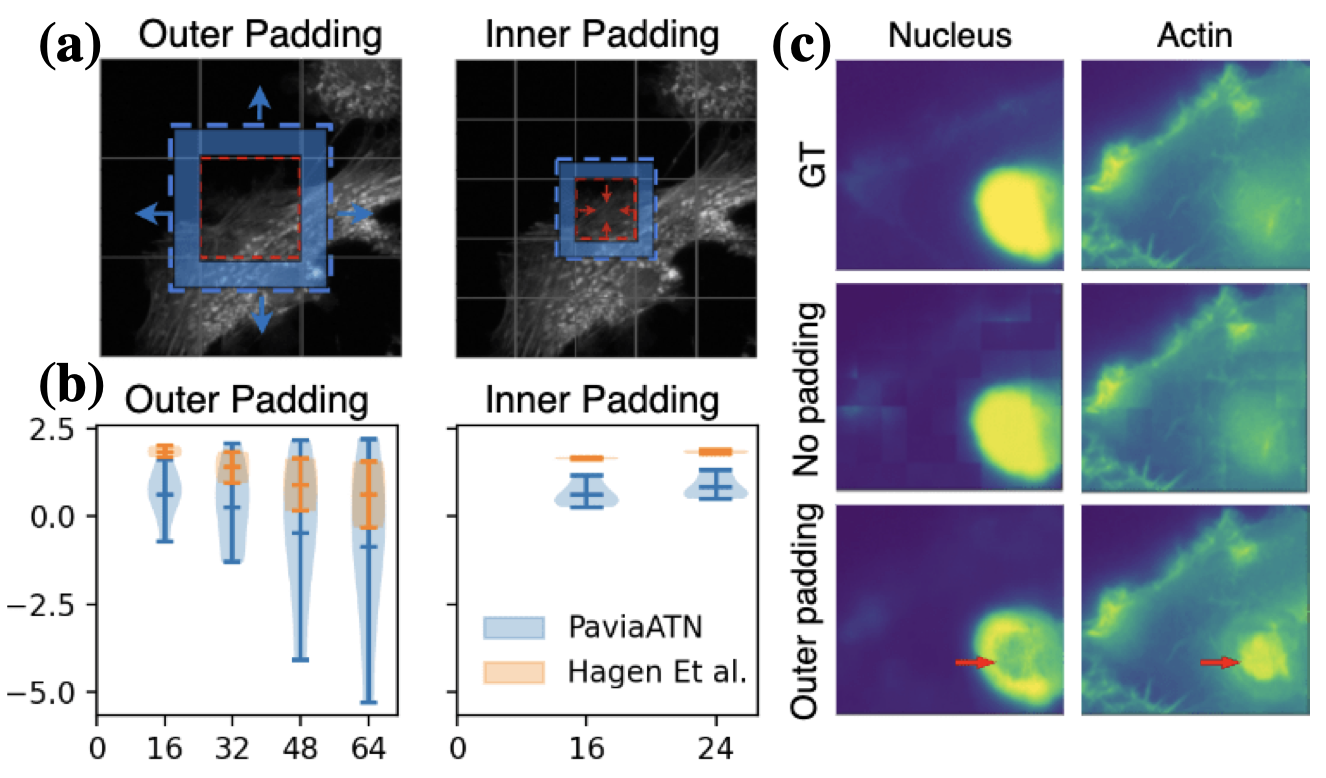

In [23]:

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
def get_save_dir(results_root, dataset, ckpt_dir):
    """
    Build save path as results_root/dataset/modality/LCtype
    """
    parts = Path(ckpt_dir).parts
    modality, lctype = parts[-2], parts[-1]
    save_dir = Path(results_root) / dataset / modality / lctype
    save_dir.mkdir(parents=True, exist_ok=True)
    return save_dir


def get_raw_preds_dir(save_dir, dataset, ckpt_dir):
    """
    Build raw predictions folder as save_dir/raw_predictions_{dataset}_{modality}_{lctype}_predid
    """
    parts = Path(ckpt_dir).parts
    modality, lctype = parts[-2], parts[-1]
    raw_dir = save_dir / f"raw_predictions_{dataset}_{modality}_{lctype}_predid"
    raw_dir.mkdir(parents=True, exist_ok=True)
    return raw_dir


def run_inference_sliding(model, test_dset,dataset,ckpt_dir,results_root,
                        batch_size=32, num_workers=4 ):
    """
    Run model inference on the test dataset, predict all tiles, and save them as .npy files.
    Does NOT check for existing predictions and does NOT stitch.
    
    Args:
        model: PyTorch model
        test_dset: Dataset for inference
        save_dir: Directory to save predictions (will be created if doesn't exist)
        batch_size: Batch size for DataLoader
        num_workers: Number of workers for DataLoader
    """
    print("Initialising")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)
    save_dir = get_save_dir(results_root, dataset, ckpt_dir)
    save_dir = Path(save_dir)
    # fast_delete(save_dir)  # deletes folder and all files 
    save_dir.mkdir(parents=True, exist_ok=True)

    print("Loading Dataloader")
    dloader = DataLoader(test_dset, pin_memory=True, num_workers=num_workers,
                         shuffle=False, batch_size=batch_size)
    print("Predicting now....")
    global_idx = 0
    with torch.no_grad():
        for batch in tqdm(dloader, desc="Predicting tiles"):
            inp = batch[0].to(device)
            rec, _ = model(inp)

            # get reconstructed img
            if model.model.predict_logvar is None:
                rec_img = rec
                logvar = torch.tensor([-1])
            else:
                rec_img, logvar = torch.chunk(rec, chunks=2, dim=1)

            rec_np = rec_img.cpu().numpy()  # shape: (batch_size, C, H, W)
            
            for i in range(rec_np.shape[0]):
                raw_pred_path = get_raw_preds_dir(save_dir, dataset, ckpt_dir)
                pred_path =  raw_pred_path / f"pred_{global_idx:010d}.npy"
                np.save(pred_path, rec_np[i])
                global_idx += 1
                
    print(f"✅ Saved {global_idx} prediction tiles to {save_dir}")



In [ ]:
run_inference_sliding(model,test_dset,"HT_LIF24",ckpt_dir,results_root)

In [22]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import get_unnormalized_predictions, get_target, get_input

# Here we use a small helper function that returns the final results
# after performing Inner Padding, as mentioned above.
# Note also that it also returns `stitched_stds`, which is the pixel-wise
# standard deviation (std) between the posterior samples we have averaged
# while computing the MMSE per patch during tiled predictions. These 
# values will become most useful at the end of this notebook and in even 
# more so in `03_calibration.ipynb` for calibration and error estimations.
stitched_predictions, norm_stitched_predictions, stitched_stds = get_unnormalized_predictions(
    model, 
    dset, EXPOSURE_DURATION, TARGET_CHANNEL_IDX_LIST, 
    mmse_count=experiment_params['mmse_count'],
    grid_size=32, 
    num_workers=experiment_params['num_workers'], 
    batch_size=64)

# load inputs and noisy targets (needed for plotting later on)
inp = get_input(dset)
tar = get_target(dset)

Predicting tiles:   0%|          | 0/28082 [00:00<?, ?it/s]


AttributeError: 'VAEModule' object has no attribute 'likelihood'

In [ ]:
save_dir = Path('predictions')
save_dir.mkdir(parents=True, exist_ok=True)
# saving the predictions as a tiff file
stitched_preds_np = np.array(stitched_predictions)
print("Shape before squeeze:", stitched_preds_np.shape)

save_tiff(save_dir / "pred_test_dset_microsplit_og.tiff", stitched_preds_np.transpose(0,3,1,2))
with open(save_dir / "pred_test_dset_microsplit_og.pkl", "wb") as f:
    dill.dump(stitched_preds_np, f)

## Overview: visualize full <nobr>Micro$\mathbb{S}$plit</nobr> predictions...

In [ ]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import full_frame_evaluation
frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

## Detailed view on some (foreground) locations...
Below, we show few random foreground locations and the corresponding <nobr>Micro$\mathbb{S}$plit</nobr> predictions.

You can execute the cell multiple times and different randomly chosen locations will be plotted.

In [ ]:
import numpy as np
from microsplit_reproducibility.utils.utils import clean_ax
from microsplit_reproducibility.notebook_utils.HT_LIF24 import pick_random_patches_with_content
import matplotlib.pyplot as plt

img_sz = 128
rand_locations = pick_random_patches_with_content(tar, 128)
h_start = rand_locations[2,0] #np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[2,1] #np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 2*len(TARGET_CHANNEL_IDX_LIST) + 1
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    ax[i,0].imshow(inp[0,h_start:h_start+img_sz, w_start:w_start+img_sz])
    for j in range(ncols//2):
        vmin = stitched_predictions[...,j].min()
        vmax = stitched_predictions[...,j].max()
        ax[i,2*j+1].imshow(tar[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)
        ax[i,2*j+2].imshow(stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)

ax[0,0].set_title('Primary Input')
for i in range(len(TARGET_CHANNEL_IDX_LIST)):
    ax[0,2*i+1].set_title(f'Target Channel {i+1}')
    ax[0,2*i+2].set_title(f'Predicted Channel {i+1}')

# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

## *Optional:* manual inspection of the predictions
<div class="alert alert-block alert-info">
<b> Task:</b> Set <i>y_start</i>, <i>x_start</i>, and <i>crop_size</i> to inspect the predictions at a  location of your choice.
</div>

In [ ]:
y_start = 600  #np.random.randint(stitched_predictions.shape[1] - crop_size)
x_start = 1150 #np.random.randint(stitched_predictions.shape[2] - crop_size)
crop_size = 128

ncols = len(TARGET_CHANNEL_IDX_LIST) + 1
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
ax[0,0].imshow(inp[0,y_start:y_start+crop_size, x_start:x_start+crop_size])
for i in range(ncols -1):
    vmin = stitched_predictions[...,i].min()
    vmax = stitched_predictions[...,i].max()
    ax[0,i+1].imshow(tar[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i], vmin=vmin, vmax=vmax)
    ax[1,i+1].imshow(stitched_predictions[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i], vmin=vmin, vmax=vmax)
    ax[0,i+1].set_title(f"Channel {i+1}")

ax[1,0].axis('off')
ax[0,0].set_title("Input")
ax[0,2].set_ylabel("Target")
ax[1,2].set_ylabel("Predicted")
ax[0,1].yaxis.set_label_position("left")
ax[0,2].yaxis.set_label_position("left")

print('Here the crop you selected:')

# ***Optional Step 2.5:*** Posterior Sampling and MMSE Predictions
For a given input patch, <nobr>Micro$\mathbb{S}$plit</nobr> can generate multiple outputs. This is possible because <nobr>Micro$\mathbb{S}$plit</nobr> is learning a full posterior of possible solutions, which is a quite powerful feature!

As we elaborate in the <nobr>Micro$\mathbb{S}$plit</nobr> paper and also later in the calibration notebook `03_calibration.ipynb`, this allows users to visually judge and even quantify the (data) uncertainty in the predictions their trained model makes.

Below, we show two posterior samples and how much they differ for a few random foreground locations. Re-run the cell to see different randomly choosen locations and corresponding posterior samples.

### Get two posterior samples and plot them...

In [ ]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import show_sampling
imgsz = 3
ncols = 6
examplecount = 3
_,ax = plt.subplots(figsize=(imgsz*ncols, imgsz*2*examplecount), ncols=ncols, nrows=2*examplecount)

show_sampling(dset, model, ax=ax[:2])
show_sampling(dset, model, ax=ax[2:4])
show_sampling(dset, model, ax=ax[4:6])
plt.tight_layout()

### The MMSE solution and why you should care...
You might hae spotted a few tiling artefacts here and there in the plots above. This is mainly caused by the fact that we are using a variational model that predicts samples from the learned posterior.

Without going into all the details, at tile-edges, the posterior samples are simply not 100% consistent (because the input is subject to uncertainties due to non-perfect inputs).

Either way, without even telling you, the predictions you computed above are not single samples as the ones we saw in the previous plot. Instead, we have created multiple posterior samples and averaged them pixel by pixel.

***But why would we do that?*** While a single posterior sample is one interpretation of the noisy and likely somewhat ambiguous input data, the Minimum Mean Square Error (MMSE) of the posterior is the expected value of the posterior. Immagine it as the average of all posteror samples!

Fun fact, if you train a U-Net with an L2 loss, the U-Net's predictions will also be an approximation of the MMSE. 👀

Anyways, the details can be confusing... the take-home message is:
**The more posterior samples you average, the closer will this average image be at the MMSE solution. MMSE solutions look nice and smooth, and they are relatively consistent when we compute tiled predictions.

All this is certainly not obvious and if you are interested to learn more, maybe check out [this](https://arxiv.org/abs/2401.01438) and [this](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf)!

But enough -- **let's compare single posterior samples with some approximate MMSE solutions**!

In [ ]:
n_samples = 50   # min: 10
if n_samples<10: n_samples=10

# choose a random input patch
from microsplit_reproducibility.notebook_utils.HT_LIF24 import pick_random_inputs_with_content

idx_list = pick_random_inputs_with_content(dset)
inp_patch, tar_patch = dset[idx_list[0]+1]

# compute individual posterior samples
samples = []
model.eval()

import torch
from tqdm.notebook import tqdm


for _ in tqdm(range(n_samples),"Sampling the posterior"):
    with torch.no_grad():
        pred_patch,_ = model(torch.Tensor(inp_patch).unsqueeze(0).to(model.device))
        samples.append(pred_patch[0,:tar_patch.shape[0]].cpu().numpy())
samples = np.array(samples)

In [ ]:
inp_patch, tar_patch = dset[idx_list[0]]

nrows=5
imgsz=3
_, ax = plt.subplots(figsize=(imgsz*2,imgsz*nrows+imgsz), ncols=len(TARGET_CHANNEL_IDX_LIST), nrows=nrows)
print(ax.shape)
ax[0,0].imshow(inp_patch[0])
ax[0,0].set_title("Input (Idx: {})".format(idx_list[0]))
ax[0,1].axis("off")


for ch in range(len(TARGET_CHANNEL_IDX_LIST)):
    ax[1, ch].imshow(samples[0, ch])
    ax[1, ch].set_title(f"C{ch+1}: Sample")
    ax[2, ch].imshow(np.mean(samples[:5,0], axis=0))
    ax[2, ch].set_title(f"C{ch+1}: MMSE (5)")
    ax[3, ch].imshow(np.mean(samples[:,0], axis=0))
    ax[3, ch].set_title(f"C{ch+1}: MMSE ({len(samples)})")
    ax[4, ch].imshow(tar_patch[0])
    ax[4, ch].set_title(f"C{ch+1}: Target")


# **Step 2.6:** Quantitative Evaluation
For the *HT-LIF24* dataset, we have invested the extra effort to also image paired high-SNR data. In order to compute performance metrics that evaluate the quality of <nobr>Micro$\mathbb{S}$plit</nobr> predictions, we will use these high-SNR 'ground truth' images as references.

Let's first load this high-SNR data... and if necessary, download it before... 

In [ ]:
from microsplit_reproducibility.notebook_utils.HT_LIF24 import get_highsnr_data
highSNR_test_dset = get_highsnr_data(train_data_config, val_data_config, test_data_config, evaluate_on_validation_data)

In [ ]:
if reduce_data:
    highSNR_test_dset.reduce_data([0])

In [ ]:
highSNR_target = highSNR_test_dset._data[..., :-1]

In [ ]:
print("Metric, followed by values for each channel")
from microsplit_reproducibility.utils.paper_metrics import compute_high_snr_stats
_ = compute_high_snr_stats(highSNR_target, stitched_predictions)

# **Step 2.7:** Saving data required for network calibration and error estimations (ie. for running `03_calibration.ipynb`)
We reached a point where we can train and use <nobr>Micro$\mathbb{S}$plit</nobr>. Only one key feature remains unexplored: the possibility to check how well calibrated a trained <nobr>Micro$\mathbb{S}$plit</nobr> network is, and then use multiple posterior samples to analyze their pixel-wise variability to ***estimate the true error*** with respect to unknown ground truth.

**Calibaration and error estimation will require:**<br>
***(i)*** target images as the one we used during training but for the *Test and Validation data* (we will store those in two files for later use),<br>
***(ii)*** saved MMSE predictions obtained with your trained model *on the Test and the Validation data* (also here we will store 2 files), and <br>
***(iii)*** saved pixel-wise standard deviations (Std) of the posterior samples we averaged to get the MMSE predictions from above (also on *Test and Validation data*, hence, yet another 2 files to be saved).

Once we created and saved all we need, the notebook `03_calibration.ipynb` does not have to deal with <nobr>Micro$\mathbb{S}$plit</nobr> models or predictions at all! 🥳

In [ ]:
# change this only if you used your own data
dataset_prefix = 'ht_lif24_'

# create folder to store all the data (6 files in total) for the calibration notebook
path_for_calibration_data = f"calibration_data/{EXPOSURE_DURATION}"
os.makedirs(path_for_calibration_data, exist_ok=True)

### ***Step 2.7.1:*** Save target data we need in the calibration notebook.
We need the training-data like target channels later in the calibration notebook, and since we have this data availabe right here, let's quickly save it into the folder we created above (the one that will contain the 6 files we talk about all the time).

In [ ]:
data_stats = experiment_params["data_stats"]
target_val = val_dset._data[..., :-1]
target_test = test_dset._data[..., :-1]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 1))

target_val_normalized  = (target_val  - sep_mean)/ sep_std
target_test_normalized = (target_test - sep_mean)/ sep_std

# store also the corresponding target data (this is just like the supervision data we used during training)
target_val_filename  = 'target_' + dataset_prefix + 'Val'
target_test_filename = 'target_' + dataset_prefix + 'Test'
tifffile.imwrite(
    f"{path_for_calibration_data}/{target_val_filename}.tif", target_val_normalized)
print(f'✅ Saved target data for Val data at "{path_for_calibration_data}/{target_val_filename}.tif"!')
tifffile.imwrite(
    f"{path_for_calibration_data}/{target_test_filename}.tif", target_test_normalized)
print(f'✅ Saved target data for Test data at "{path_for_calibration_data}/{target_test_filename}.tif"!')

In [ ]:
target_val_normalized.shape

### ***Step 2.7.2:*** Save the MMSE predictions and Std from Step 2.4.
Wee need four more things to have all the data for the calibration notebook together. More specifically, and as mentioned before, we need:
*(i)* the MMSE predictions for the Validation data, 
*(ii)* the MMSE predictions for the Test data,
*(iii)* the standard deviation (Std) of the posterior samples we drew to generate the MMSE predictions for the Validation data, and
*(iv)* the standard deviation (Std) of the posterior samples we drew to generate the MMSE predictions for the Test data.

Two of these four missing pieces we have computed above, depending on what you choose to work with, Validation or Training data (you made this choice in Step 2.1).
If you want to be prepared for the next notebook and haven't already, go back to Step 2.1, and set <i> evaluate_on_validation_data = True </i> and re-run the cells in the remainer of the notebook. Make sure `reduce_data` parameter setting is consistent. 

In [ ]:
# Let us make somewhat sure that this notebook is not in 'bad shape'
# (i) are the generated predictions of same shape?
assert norm_stitched_predictions.shape == stitched_stds.shape, "MMSE predictions and pixel-wise stds have incompatible shape. Please redo Step 2.4 of this notebook!"
# (ii) and is the high-SNR data loaded in Step 2.6 fitting inputs and predictions?
assert stitched_stds.shape == highSNR_target.shape, "Shape of predictions does not fit to shape of loaded inputs. Please check that the notebook is in a consistent sate!"

# check if user predicted on validation or test data
val_or_test = ('Val' if evaluate_on_validation_data else 'Test')

# print what we found for user
print(f'✅ Looks like predictions for {val_or_test} data were created above.\nWe will save those predictions in the next cell...')
the_other = ('Test' if evaluate_on_validation_data else 'Val')

In [ ]:
# store the predictions currently available in this notebook (created in Step 2.4 (predictions))
pred_filename = 'prediction_' + dataset_prefix + val_or_test
std_filename  = 'std_'        + dataset_prefix + val_or_test
tifffile.imwrite(
    f"{path_for_calibration_data}/{pred_filename}.tif", norm_stitched_predictions)
print(f'✅ Saved MMSE predictions for {val_or_test} data at "{path_for_calibration_data}/{pred_filename}.tif"!')
tifffile.imwrite(
    f"{path_for_calibration_data}/{std_filename}.tif", stitched_stds)
print(f'✅ Saved posterior sample Stds for {val_or_test} data at "{path_for_calibration_data}/{pred_filename}.tif"!')

print(f'\n‼️ Please ensure to also create and save these two files also for the {the_other} data!')
print(f'You are only ready for the calibration notebook once the folder "{path_for_calibration_data}" contain 6 files in total!')


**If 6 files like the ones show below are in the above mentioned folder you are done here! 👍**
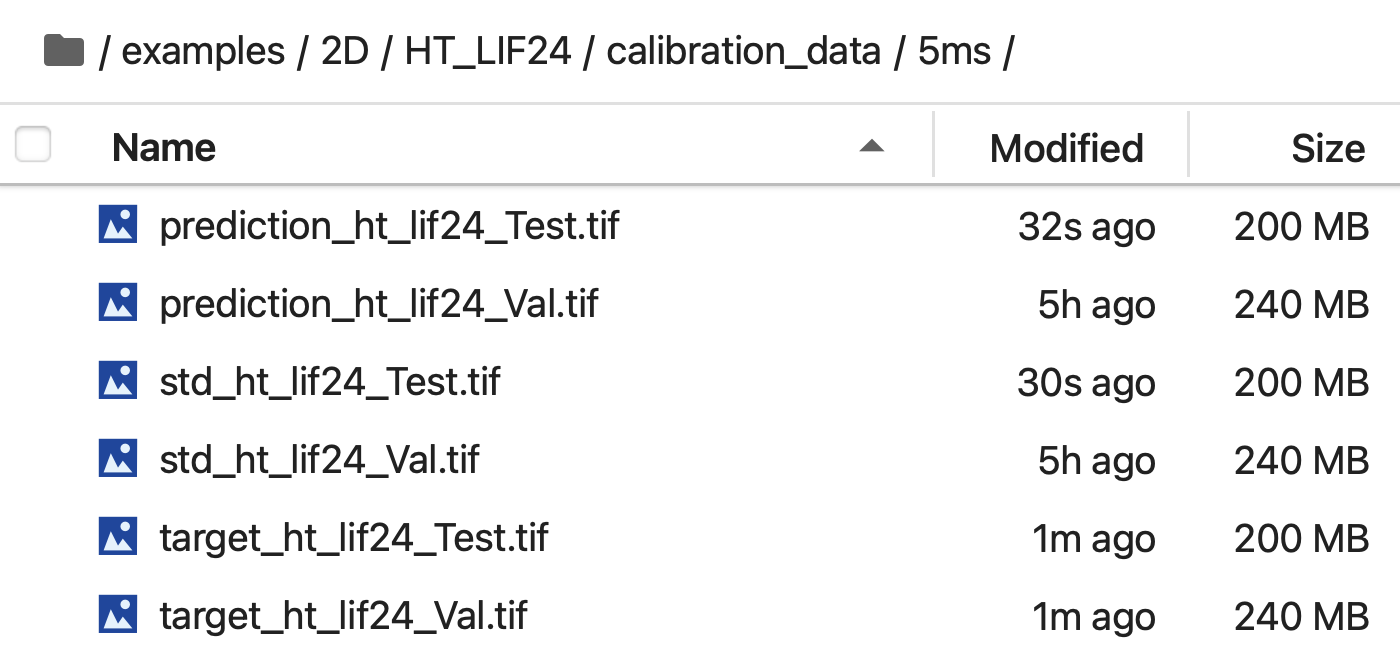
### Congratulations, done, that is fantastic! 🎉